In [1]:
# Mark Minivini Stronger Stocks Momentum

Scan for the strongest performing stock in terms of price increases over 1 months, 3 months and 6 months.

- If the market is going down and these stocks are increasing (or even trading sideways) then the stock is screaming that it is stronger than the overall market.
- If the market is going up, then it could signal that the market acts as leverage to the stock (e.g. a 10% increase in the market may mean a 100% increase in the stock).

In [50]:
import pandas as pd

# Replace with the actual path to your input CSV file
input_csv_path = '../data/ind_niftysmallcap100list.csv'

# Replace with the actual path where you want to save the updated CSV file
output_csv_path = '../data/updated_niftysmallcap100_stocks.csv'


# Read the original CSV file
data = pd.read_csv(input_csv_path)

# Print the column names to verify the correct column name
print("Column names:", data.columns)

# Copy the "Industry" column data to a new column named "Original_Industry"
if 'Industry' in data.columns:
    data['Original_Industry'] = data['Industry']
else:
    print("Error: 'Industry' column not found in the input CSV file.")

# Create a new "Symbol" column with ".NS" appended to the values
data['Symbol'] = data['Symbol'].apply(lambda x: f'{x}.NS')

# Save the updated data to a new CSV file
data.to_csv(output_csv_path, index=False)

print(f"Updated data saved to {output_csv_path}")


Column names: Index(['Company Name', 'Industry', 'Symbol', 'Series', 'ISIN Code'], dtype='object')
Updated data saved to ../data/updated_niftysmallcap100_stocks.csv


In [51]:
import pandas as pd
import yfinance as yf

GROWTH_SINCE = '2023-12-01'  # The lower date to calculate the stock performance
GROUPBY_COL = 'Industry'  # Use 'Industry' instead of 'GICS Sector' or 'GICS Sub-Industry'
CSV_FILE_PATH = '../data/updated_niftysmallcap100_stocks.csv'  # Replace with the actual path to your CSV file
NUM_PER_GROUP = 4  # The top n winning stocks per group

if __name__ == '__main__':
    
    # Read the S&P500 stock information from the CSV file
    ticker_info = pd.read_csv(CSV_FILE_PATH)
    
    # Use the original ticker symbols without any modifications
    tickers = ticker_info['Symbol'].unique().tolist()
    
    # Download the price data for all the stocks in the S&P list
    ticker_prices = yf.download(
        tickers,
        start=GROWTH_SINCE,
        threads=True,
    )
    
    # Ensure that the MultiIndex is lexicographically sorted
    ticker_prices = ticker_prices.sort_index(axis=1, level=0)
    
    # Filter to only the closing prices (this is used for the comparison)
    ticker_prices = ticker_prices[
        [col for col in ticker_prices.columns if col[0] == 'Close']
    ]
    
    # Clean up the price dataframe, noting we don't require the date column
    # since we are calculating the performance over the entire interval
    ticker_prices = (
        ticker_prices
        .dropna()
        .reset_index()
        .drop(columns='Date')
    )
    
    # Find the stock growth in percent
    growth = 100 * (ticker_prices.iloc[-1] / ticker_prices.iloc[0] - 1)
    
    # Cleaning of the growth pandas series, changing it back to a dataframe
    # so that we can merge with the sector/industry to find the winning stocks
    # per that group
    growth = (
        growth
        .to_frame()
        .reset_index()
        .drop(columns=['level_0'])
        .rename(columns={'level_1': 'Symbol', 0: 'Growth'})
    )
    
    # Merge the growth with the ticker information dataframe to obtain the
    # column used for the groupby
    growth = growth.merge(
        ticker_info[['Symbol', GROUPBY_COL]],
        on='Symbol',
        how='left',
    )
    
    # Find the ranking of each stock per sector
    growth['sector_rank'] = (
        growth
        .groupby(GROUPBY_COL)
        ['Growth']
        .rank(ascending=False)
    )
    
    # Filter to only the winning stocks, and sort the values
    growth = (
        growth[growth['sector_rank'] <= NUM_PER_GROUP]
        .sort_values(
            [GROUPBY_COL, 'Growth'],
            ascending=False,
        )
    )

    print(growth)


[*********************100%%**********************]  100 of 100 completed

           Symbol      Growth                           Industry  sector_rank
82     RAYMOND.NS   17.568392                           Textiles          1.0
98  WELSPUNLIV.NS   -0.223218                           Textiles          2.0
42        HFCL.NS   62.546816                  Telecommunication          1.0
87       ROUTE.NS    3.373592                  Telecommunication          2.0
94        TTML.NS   -6.641870                  Telecommunication          3.0
92    TEJASNET.NS   -7.236113                  Telecommunication          4.0
84   REDINGTON.NS   31.193238                           Services          1.0
36         FSL.NS   15.354111                           Services          2.0
88        SJVN.NS   42.461714                              Power          1.0
75    NLCINDIA.NS   35.875629                              Power          2.0
22        CESC.NS   27.213929                              Power          3.0
71        MRPL.NS   91.379311         Oil Gas & Consumable Fuels


/tmp/ipykernel_12278/2656974246.py:35: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [52]:
# Save the output to a CSV file
output_csv_path = '../data/nifty_smallcap_100_high_performers.csv'  # Replace with the desired path
growth.to_csv(output_csv_path, index=False)

print(f"Output saved to {output_csv_path}")


Output saved to ../data/nifty_smallcap_100_high_performers.csv


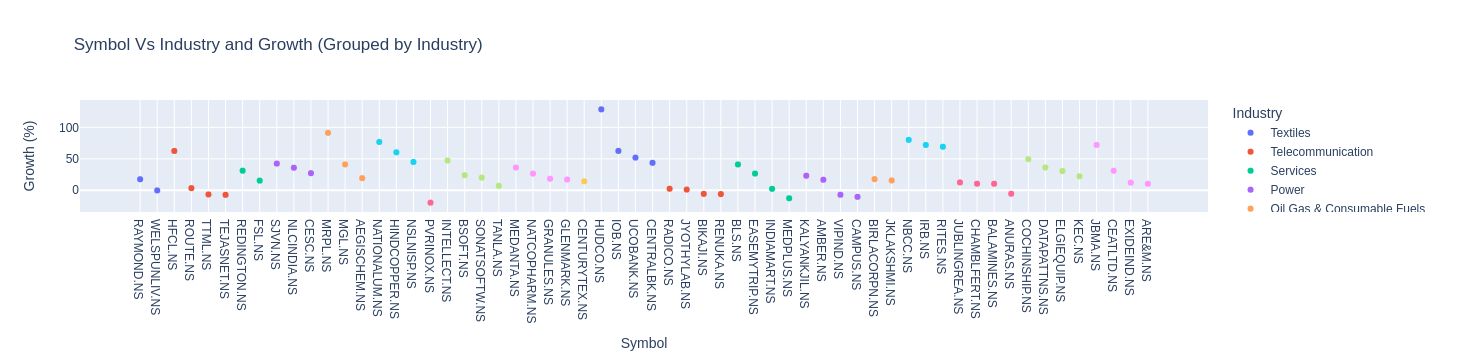

In [53]:
import pandas as pd
import plotly.express as px


# Replace with the actual path to your output CSV file
output_csv_path = '../data/nifty_smallcap_100_high_performers.csv'


# Read the output CSV file
output_data = pd.read_csv(output_csv_path)

# Scatter plot using Plotly Express, grouped by 'Industry'
fig = px.scatter(
    output_data,
    x='Symbol',
    y='Growth',
    color='Industry',
    title='Symbol Vs Industry and Growth (Grouped by Industry)',
    labels={'Growth': 'Growth (%)', 'Symbol': 'Symbol'},
    category_orders={'Industry': output_data['Industry'].unique()},  # Preserve original order of industries
)
# Show the plot
fig.show()

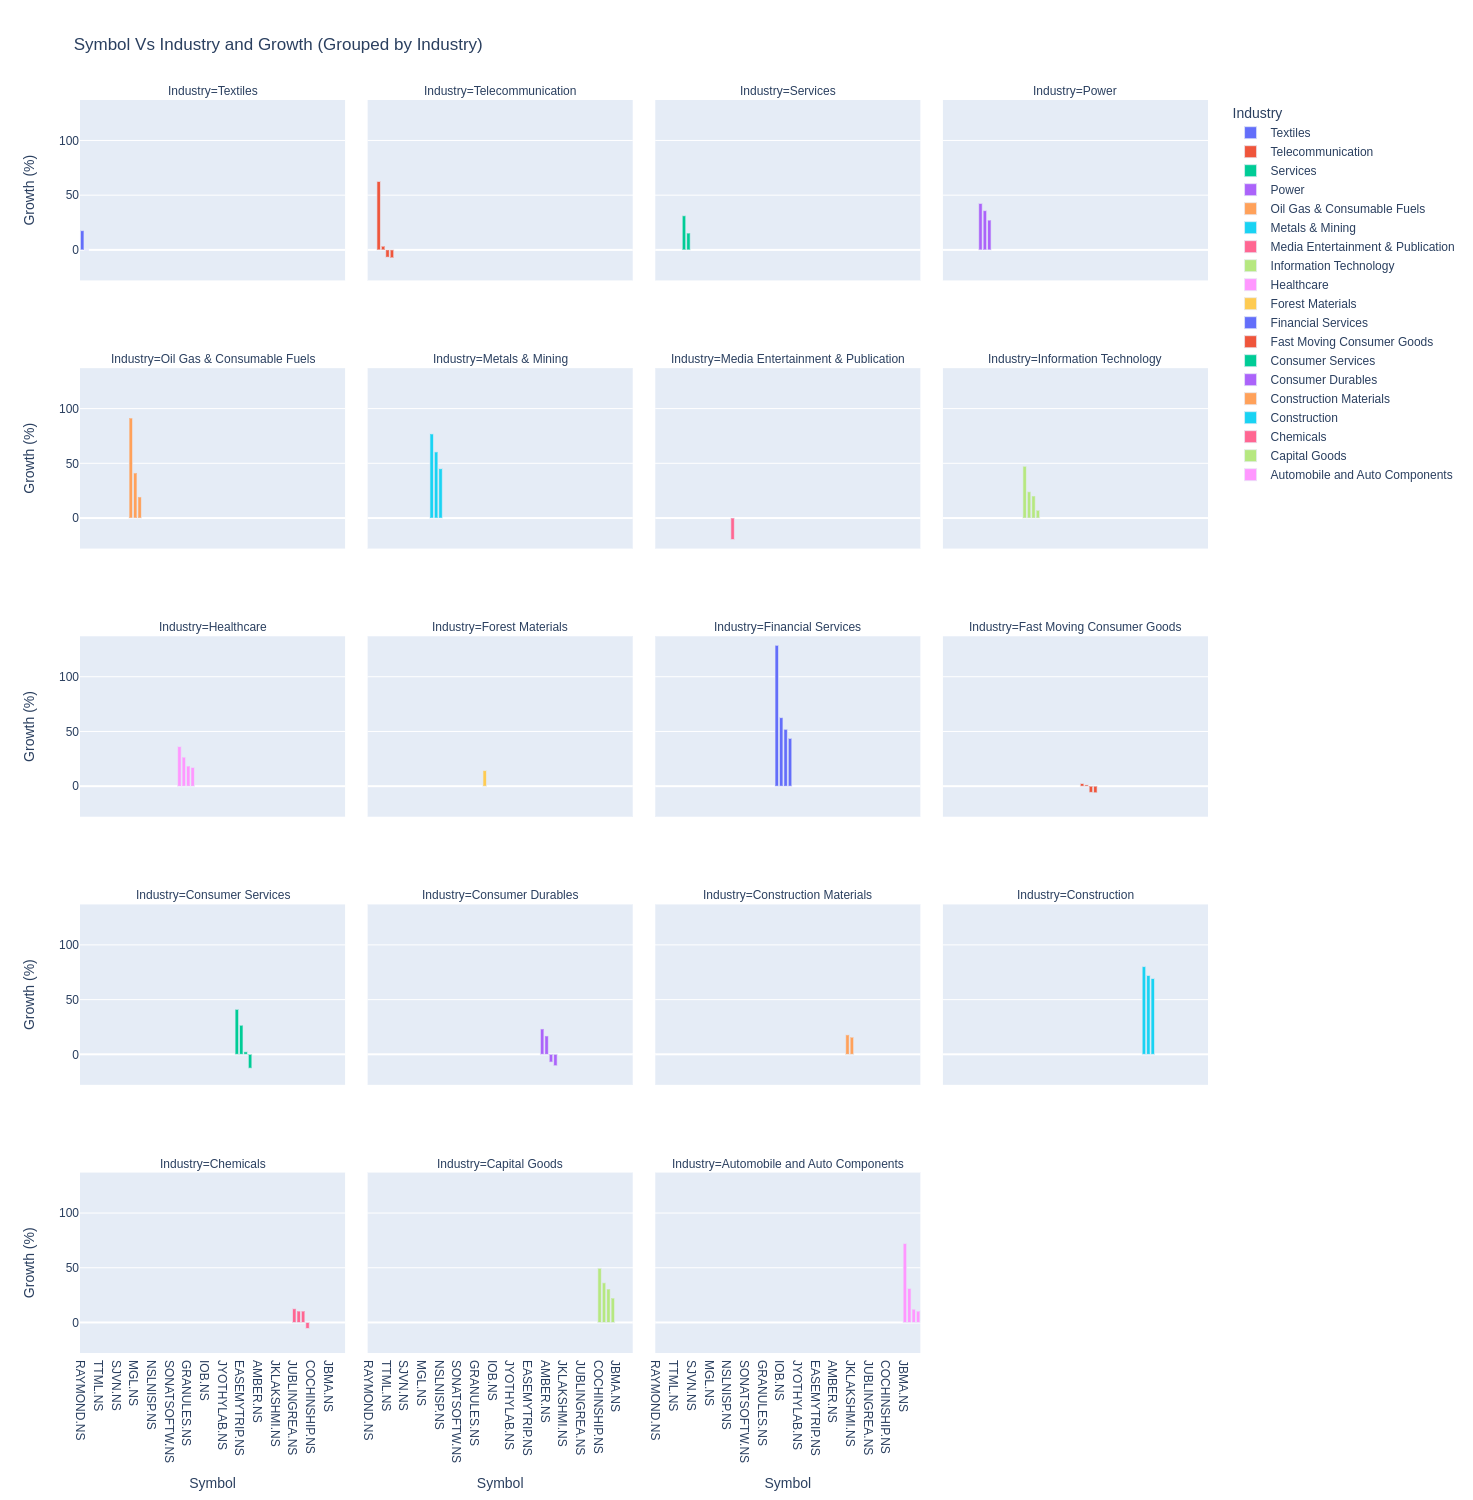

In [54]:
import pandas as pd
import plotly.express as px

# Replace with the actual path to your output CSV file
output_csv_path = '../data/nifty_smallcap_100_high_performers.csv'

# Read the output CSV file
output_data = pd.read_csv(output_csv_path)

# Bar chart using Plotly Express, grouped by 'Industry'
fig = px.bar(
    output_data,
    x='Symbol',
    y='Growth',
    color='Industry',
    title='Symbol Vs Industry and Growth (Grouped by Industry)',
    labels={'Growth': 'Growth (%)', 'Symbol': 'Symbol'},
    category_orders={'Industry': output_data['Industry'].unique()},  # Preserve original order of industries
    facet_col='Industry',  # Create separate subplots for each industry
    facet_col_wrap=4,  # Adjust the number of subplots per row as needed
    height=1500,  # Adjust the height of the entire figure
    width=1800,  # Adjust the width of the entire figure
)

# Show the plot
fig.show()
